# First Analysis of Results from Exact Diagonalization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hydra
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional


from hydra import compose, initialize
from omegaconf import OmegaConf

In [2]:
from typing import Callable

# every argument after * must be passed as a keyword argument
def plot_xy(
    x: np.ndarray,
    y: np.ndarray,
    *,
    xlabel: str,
    ylabel: str,
    title: str,
    loglog: bool = False,
    guide_line: Callable | None = None,
    guide_label: str | None = None
):
    """
    Generic plotting helper.

    Parameters
    ----------
    x, y : array-like
        Data to plot.
    xlabel, ylabel, title : str
        Axis labels and title.
    loglog : bool
        If True, make a log-log plot.
    guide_line : callable
        A function f(x) that returns a reference line to plot.
    guide_label : str
        Label for the reference line.
    """
    plt.figure()

    if loglog:
        plt.loglog(x, y, label=ylabel)
        if guide_line is not None:
            plt.loglog(x, guide_line(x), 'k--', label=guide_label)
    else:
        plt.plot(x, y, label=ylabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def plot_photon_number_vs_omega(omega_list, photon_numbers):
    plot_xy(
        omega_list, photon_numbers,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Photon Frequency"
    )

def plot_photon_number_vs_omega_log_log(omega_list, photon_numbers):
    plot_xy(
        omega_list, photon_numbers,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Photon Frequency (Log-Log Scale)",
        loglog=True
    )

def plot_entanglement_entropy_vs_omega_log_log(omega_list, entropies):
    plot_xy(
        omega_list, entropies,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel='Entanglement Entropy',
        title="Entanglement Entropy vs Photon Frequency (Log-Log Scale)",
        loglog=True,
        guide_line=lambda x: 1/x**2,
        guide_label=r'$1/\Omega^2$'
    )

def plot_photon_number_vs_U(U_list, photon_numbers):
    plot_xy(
        U_list, photon_numbers,
        xlabel='Interaction Strength U',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Interaction Strength U"
    )

def plot_entanglement_entropy_vs_U(U_list, entropies):
    plot_xy(
        U_list, entropies,
        xlabel='Interaction Strength U',
        ylabel='Entanglement Entropy',
        title="Entanglement Entropy vs Interaction Strength U"
    )


def plot_correlation_differences_vs_U(U_list, correlation_differences):
    plot_xy(
        U_list, correlation_differences,
        xlabel='Interaction Strength U',
        ylabel='Correlation Differences',
        title="Correlation Differences vs Interaction Strength U"
    )


def plot_ground_state_amplitudes_vs_U(U_list: np.ndarray, ground_states: np.ndarray):
    # plot the absolute square of the ground state coefficients per sites for various U
    # as a colormap. Start at the top of the plot with the lowest U and go down to highest U
    plt.figure()
    plt.imshow(np.abs(ground_states)**2, aspect='auto', extent=[0, len(ground_states[0]), U_list[-1], U_list[0]]) # type: ignore
    plt.colorbar(label='|Coefficient|^2')
    plt.xlabel('Basis State Index')
    plt.ylabel('Interaction Strength U')
    plt.title('Ground State Coefficients vs Interaction Strength U')
    plt.show()


# def plot_ground_state_vs_U(basis: Basis, U_list: np.ndarray, ground_states: np.ndarray):
#     # assume that we have purely fermionic basis for now
#     # take the state with the highest amplitude in each ground state, obtain its binaray representation
#     # and plot its occupation per site vs U
#     L = basis.L
#     dominant_states = []
#     for gs in ground_states:
#         max_idx = np.argmax(np.abs(gs))
#         dominant_state = basis.states[max_idx]
#         dominant_states.append(dominant_state)

#     plt.figure()
#     for site in range(L):
#         occupations = [(state[0] >> site) & 1 for state in dominant_states]
#         plt.plot(U_list, occupations, label=f'Site {site}')
#     plt.xlabel('Interaction Strength U')
#     plt.ylabel('Occupation')
#     plt.title('Dominant Ground State Occupation vs Interaction Strength U')
#     plt.legend()
#     plt.grid()
#     plt.show()

In [3]:



def plot_multi_xy(
    curves: list[tuple[np.ndarray, np.ndarray, str]],
    *,
    xlabel: str,
    ylabel: str,
    title: str,
    loglog: bool = False,
    guide_line: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    guide_label: Optional[str] = None,
):
    """
    Plot multiple (x, y) curves in a single figure.

    curves: list of (x, y, label) tuples
    """
    plt.figure()

    # Plot optional guide function (must use the x-values of the first curve)
    if loglog and guide_line is not None:
        x0, _, _ = curves[0]
        plt.loglog(x0, guide_line(x0), 'k--', label=guide_label)

    # Plot each curve
    for x, y, label in curves:
        if loglog:
            plt.loglog(x, y, label=label)
        else:
            plt.plot(x, y, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def plot_observable_vs_U_multi(results_dict, observable):
    curves = []
    for N_ph, results in results_dict.items():
        U_list, photon_nums = results
        curves.append((U_list, photon_nums, f"N_ph={N_ph}"))

    plot_multi_xy(
        curves,
        xlabel="U",
        ylabel=observable,
        title=f"{observable} vs U for Different Photon Cutoffs",
    )

def loglog_plot_observable_vs_omega_multi(results_dict, observable):
    curves = []
    for N_ph, results in results_dict.items():
        omega_list, entropies = results
        curves.append((omega_list, entropies, f"N_ph={N_ph}"))

    if observable == "entanglement_entropy":
        guide_line=lambda x: 1/x**2
        guide_label=r'$\propto 1/\Omega^2$'
    else:
        guide_line=None
        guide_label=None

    plot_multi_xy(
        curves,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=observable,
        title=f'{observable} vs Omega (Different Photon Cutoffs)',
        loglog=True,
        guide_line=guide_line,
        guide_label=guide_label
    )





In [4]:
initialize(version_base=None, config_path="../../../configs")
cfg = compose(config_name="config")
print(OmegaConf.to_yaml(cfg))

method: ed
seed: 42
root_data_dir: /data/xxz_cavity/${method}/
overwrite_existing: false
system:
  L: 4
  N_f: ${half_filling:${system.L}}
  N_ph: 2
  boundary_conditions: periodic
sweeps:
  photon_number:
    U_sweep:
      parameters:
        t: 1.0
        g0: 0.5
        g: ${gscale:${sweeps.photon_number.U_sweep.parameters.g0},${system.L}}
        omega: 10.0
        U_min: 0.0
        U_max: 20.0
        U_points: 100
    omega_sweep:
      parameters:
        t: 1.0
        g0: 0.5
        g: ${gscale:${sweeps.photon_number.omega_sweep.parameters.g0},${system.L}}
        U: 3.0
        omega_min: 1.0
        omega_max: 100.0
        omega_points: 13
  entanglement_entropy:
    U_sweep:
      parameters:
        t: ${sweeps.photon_number.U_sweep.parameters.t}
        g0: ${sweeps.photon_number.U_sweep.parameters.g0}
        g: ${sweeps.photon_number.U_sweep.parameters.g}
        omega: ${sweeps.photon_number.U_sweep.parameters.omega}
        U_min: ${sweeps.photon_number.U_sweep.

## Sweep Results

### Figure 1

In [5]:
def get_matching_result_dir(observable: str, base_dir_name: str, base_path: str) -> None | str:
    """
    Given a base path, check if there is a directory starting with the observable name.
    If exactly one matching directory is found, add it to result_paths under the observable key.
    If none or multiple matching directories are found, print a message and do not add anything.
    Arguments:
        observable (str): The observable name to look for.
        base_dir_name (str): The base directory name to match.
        base_path (str): The base path where to look for matching directories.
    Returns:
        str | None: The matching result directory path if found, otherwise None.
    """
    # check if there is a directory starting with base_path
    matching_dirs = [d for d in os.listdir(os.path.dirname(base_path)) if d.startswith(base_dir_name)]
    if not matching_dirs:
        print(f"No matching directories found for observable {observable} in {base_path}")
        return None
    elif len(matching_dirs) > 1:
        print(f"Multiple matching directories found for observable {observable} in {base_path}: {matching_dirs}")
        return None
    result_path = os.path.join(os.path.dirname(base_path), matching_dirs[0])
    return result_path

def load_results(result_paths: dict) -> dict:
    """
    Load results from the given result paths.
    Arguments:
        result_paths (dict): Dictionary mapping observable names to their result directory paths.
    Returns:
        dict: Dictionary mapping observable names to their loaded results.
    """
    results = {}
    for observable, path in result_paths.items():
        results_file = os.path.join(path, "results.npy")
        if not os.path.exists(results_file):
            print(f"Results file not found for observable {observable} in {path}")
            continue
        results[observable] = np.load(results_file)
    return results

In [7]:
root_data_dir = cfg.root_data_dir
analysis_type = "U_sweep"
observables = ["photon_number", "entanglement_entropy"]
L = 10
N_f = L // 2
N_ph = 18
boundary_conditions = "open"
t = 1.0
g0 = 0.5
base_dir_name = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions={boundary_conditions}_t={t}_g0={g0}"
result_paths = {}
for observable in observables:
    base_path = os.path.join(root_data_dir, observable, analysis_type, base_dir_name)
    # check if there is a directory starting with base_path
    result_path = get_matching_result_dir(observable, base_dir_name, base_path)
    if result_path is not None:
        result_paths[observable] = result_path

print("Result paths found:")
for obs, path in result_paths.items():
    print(f"{obs}: {path}")


Result paths found:
photon_number: /data/xxz_cavity/ed/photon_number/U_sweep/L=10_N_f=5_N_ph=18_boundary_conditions=open_t=1.0_g0=0.5_omega=10.0
entanglement_entropy: /data/xxz_cavity/ed/entanglement_entropy/U_sweep/L=10_N_f=5_N_ph=18_boundary_conditions=open_t=1.0_g0=0.5_omega=10.0


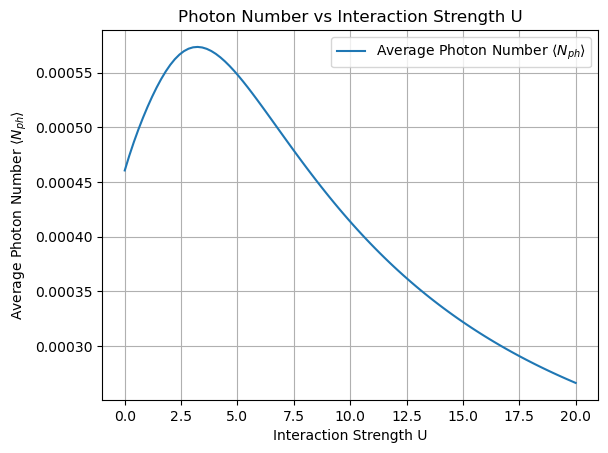

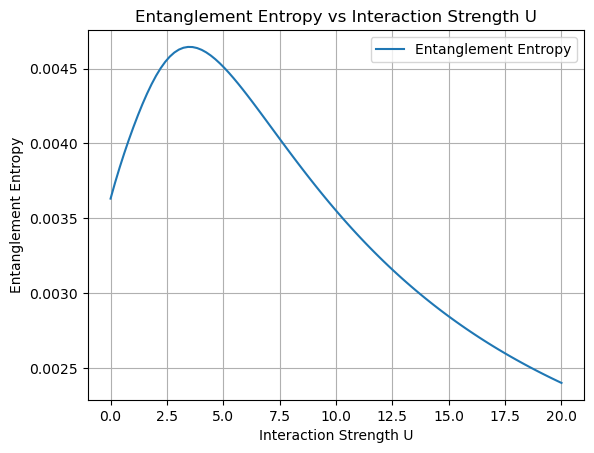

In [8]:
# load and plot the results
results = load_results(result_paths)

# take results for highest photon cutoff and plot them separately
x_vals, photon_numbers = results["photon_number"]
x_vals, entropies = results["entanglement_entropy"]

if analysis_type == "U_sweep":
    plot_photon_number_vs_U(x_vals, photon_numbers)
    plot_entanglement_entropy_vs_U(x_vals, entropies)
elif analysis_type == "omega_sweep":
    plot_photon_number_vs_omega_log_log(x_vals, photon_numbers)
    plot_entanglement_entropy_vs_omega_log_log(x_vals, entropies)


### Figure 2.a

In [9]:
observable = "photon_number_distribution"
root_data_dir = cfg.root_data_dir
analysis_type = "single_evaluations"
L = 10
N_f = L // 2
N_ph = 18
boundary_conditions = "open"
t = 1.0
g0 = 0.3
U = 3.0
omega = 1.0
base_dir_name = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions={boundary_conditions}_t={t}_g0={g0}_U={U}"


base_path = os.path.join(root_data_dir, observable, analysis_type, base_dir_name)
# check if there is a directory starting with base_path
result_path = get_matching_result_dir(observable, base_dir_name, base_path)

print("Result path found:")
print(result_path)

Result path found:
/data/xxz_cavity/ed/photon_number_distribution/single_evaluations/L=10_N_f=5_N_ph=18_boundary_conditions=open_t=1.0_g0=0.3_U=3.0_omega=1.0


In [10]:
# load and plot the results
results = np.load(os.path.join(result_path, "results.npy"))
print("Photon number distribution loaded:")
print(results)

Photon number distribution loaded:
[9.94881126e-01 5.02936142e-03 8.82986677e-05 1.19364124e-06
 1.99442140e-08 3.38919985e-10 6.11008086e-12 1.13765823e-13
 2.18430008e-15 4.29649778e-17 8.62972132e-19 1.76474794e-20
 3.66650128e-22 7.72607912e-24 1.64895399e-25 3.55981383e-27
 7.76857310e-29 1.73167479e-30 8.39835682e-32]


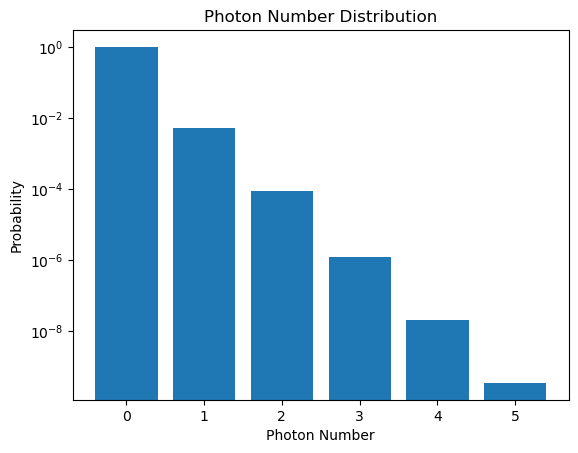

In [11]:
# plot the first n entries of the photon number distribution with a log scale on y-axis as a bar plot
n = 6
plt.figure()
plt.bar(range(n), results[:n])
plt.yscale('log')
plt.xlabel('Photon Number')
plt.ylabel('Probability')
plt.title('Photon Number Distribution')
plt.show()

### Figure 2.b

In [12]:
observable = "longest_range_correlation"
root_data_dir = cfg.root_data_dir
sweep = "U_sweep"
L = 10
N_f = L // 2
N_ph = 18
boundary_conditions = "open"
t = 1.0

result_paths = {}
for g0 in [0, 0.3]:
    base_dir_name = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions={boundary_conditions}_t={t}_g0={g0}_"
    base_path = os.path.join(root_data_dir, observable, sweep, base_dir_name)
    # check if there is a directory starting with base_path
    result_path = get_matching_result_dir(observable, base_dir_name, base_path)
    if result_path is not None:
        result_paths[f"{observable}_g0={g0}"] = result_path

print("Result paths found:")
for obs, path in result_paths.items():
    print(f"{obs}: {path}")

Result paths found:
longest_range_correlation_g0=0: /data/xxz_cavity/ed/longest_range_correlation/U_sweep/L=10_N_f=5_N_ph=18_boundary_conditions=open_t=1.0_g0=0_omega=1.0
longest_range_correlation_g0=0.3: /data/xxz_cavity/ed/longest_range_correlation/U_sweep/L=10_N_f=5_N_ph=18_boundary_conditions=open_t=1.0_g0=0.3_omega=1.0


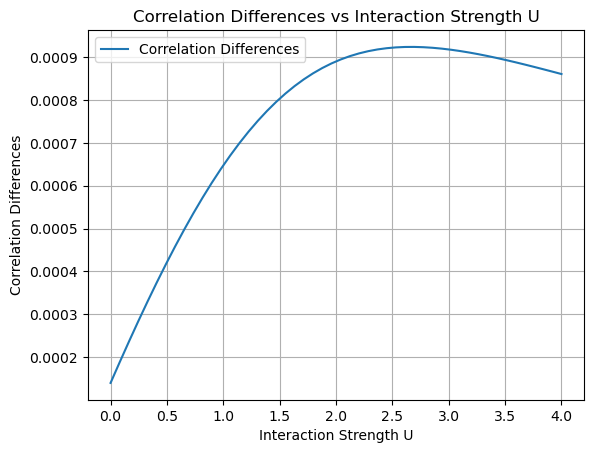

In [13]:
# load and plot results 
results = load_results(result_paths)

U_list = results["longest_range_correlation_g0=0"][0]
g_finite_minus_g_zero = results["longest_range_correlation_g0=0.3"][1] - results["longest_range_correlation_g0=0"][1]
plot_correlation_differences_vs_U(U_list, g_finite_minus_g_zero)

## Convergence Checks

In [14]:
root_data_dir = cfg.root_data_dir
sweep = "convergence_check"
observables = ["photon_number", "entanglement_entropy", "longest_range_correlation"]
L = 10
N_f = L // 2
boundary_conditions = "open"
t = 1.0
U = 2.4
g0 = 4.0
base_dir_name = f"L={L}_N_f={N_f}_boundary_conditions={boundary_conditions}_t={t}_g0={g0}_U={U}"
result_paths = {}
for observable in observables:
    base_path = os.path.join(root_data_dir, observable, sweep, base_dir_name)
    # check if there is a directory starting with base_path
    result_path = get_matching_result_dir(observable, base_dir_name, base_path)
    if result_path is not None:
        result_paths[observable] = result_path

print("Result paths found:")
for obs, path in result_paths.items():
    print(f"{obs}: {path}")

Result paths found:
photon_number: /data/xxz_cavity/ed/photon_number/convergence_check/L=10_N_f=5_boundary_conditions=open_t=1.0_g0=4.0_U=2.4_omega=1.0
entanglement_entropy: /data/xxz_cavity/ed/entanglement_entropy/convergence_check/L=10_N_f=5_boundary_conditions=open_t=1.0_g0=4.0_U=2.4_omega=1.0
longest_range_correlation: /data/xxz_cavity/ed/longest_range_correlation/convergence_check/L=10_N_f=5_boundary_conditions=open_t=1.0_g0=4.0_U=2.4_omega=1.0


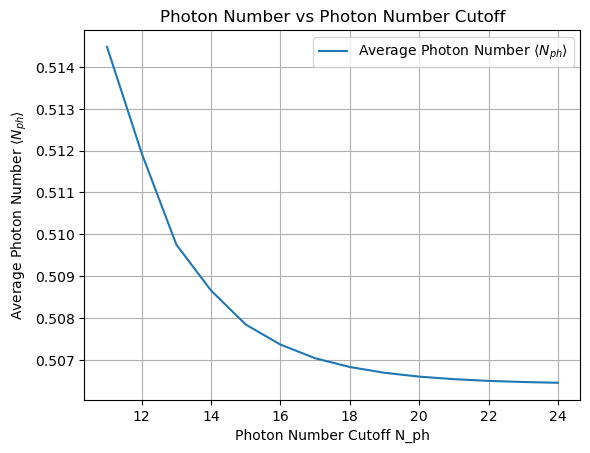

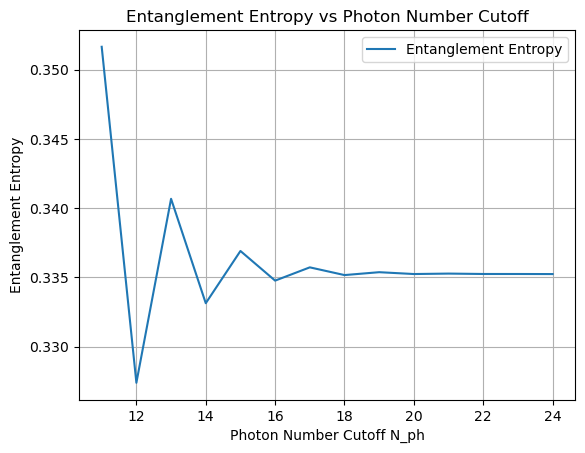

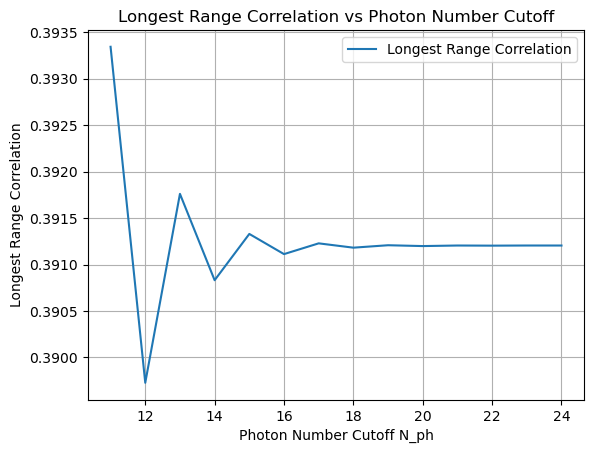

In [15]:
# load and plot the results
results = load_results(result_paths)

n_start = 6

# make plots for each observable
for observable, results in results.items():
    # throw away the first n_start data points
    results = (results[0][n_start:], results[1][n_start:])
    if observable == "photon_number":
        plot_xy(
            results[0], results[1],
            xlabel='Photon Number Cutoff N_ph',
            ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
            title='Photon Number vs Photon Number Cutoff'
        )
    elif observable == "entanglement_entropy":
        plot_xy(
            results[0], results[1],
            xlabel='Photon Number Cutoff N_ph',
            ylabel='Entanglement Entropy',
            title='Entanglement Entropy vs Photon Number Cutoff'
        )
    elif observable == "longest_range_correlation":
        plot_xy(
            results[0], results[1],
            xlabel='Photon Number Cutoff N_ph',
            ylabel='Longest Range Correlation',
            title='Longest Range Correlation vs Photon Number Cutoff'
        )
